## 一、简述
城市地区的人口流动性较强，难以直接获得某一个特定较小区域内的人口数，并且常住人口分布难以体现城市的人口流动性。所以，我们尝试将到达一个区域的行程次数视为该区域的人口（可以理解为该城市某一特定区域实际的平均每日人口），它与实际的平均每日人口大致成正比$^{[1]}$。它可能能较好的反应该区域的活动强度。

[1] Liang Xiao, Zhao Jichang, Dong Li and Xu Ke. 2013. Unraveling the Origin of Exponential Law in Intra-Urban Human Mobility. Scientific Reports, 3: 2983.

## 二、区域人口计算

In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, box

In [23]:
# 读取网格数据
grid_df = pd.read_csv("./data/grid/shanghai_grid_wgs84.csv")

# 将网格数据转换为GeoDataFrame
grid_geometries = grid_df.apply(
    lambda row: box(row['min_x'], row['min_y'], row['max_x'], row['max_y']),
    axis=1
)
grid = gpd.GeoDataFrame(
    grid_df,
    geometry=grid_geometries,
    crs="EPSG:4326"
)

In [3]:
# 读取出行记录
trips = pd.read_csv("./data/simplified_trips/simplified_trips.csv")

# 将出行记录的终点转换为GeoDataFrame
trips['geometry'] = trips.apply(lambda row: Point(row['x_d'], row['y_d']), axis=1)
trips_gdf = gpd.GeoDataFrame(trips, geometry='geometry', crs="EPSG:4326")

In [4]:
# 空间连接：将出行记录分配到网格
joined = gpd.sjoin(trips_gdf, grid, how='inner', predicate='within')

# 计算每个网格的到达次数
arrival_counts = joined.groupby('grid_id').size().reset_index(name='arrival_count')

# 将结果合并到网格数据
result_df = grid.merge(arrival_counts, on='grid_id', how='left')
result_df['arrival_count'] = result_df['arrival_count'].fillna(0)  # 将NaN替换为0

# 保存结果
result_df.to_csv("./data/grid/shanghai_grid_with_arrivals.csv", index=False)

In [5]:
import folium
from branca.colormap import linear

# 创建颜色映射
colormap = linear.YlOrRd_09.scale(
    result_df['arrival_count'].min(),
    result_df['arrival_count'].max()
)

# 创建地图
m = folium.Map(location=[31.23, 121.47], zoom_start=10)

# 添加网格
for _, row in result_df.iterrows():
    folium.Rectangle(
        bounds=[
            [row['min_y'], row['min_x']],  # 左下角
            [row['max_y'], row['max_x']]   # 右上角
        ],
        color=colormap(row['arrival_count']),
        fill=True,
        fill_opacity=0.7,
        weight=1
    ).add_to(m)

# 添加颜色条
colormap.caption = '到达次数'
colormap.add_to(m)

# 显示地图
m.save('shanghai_arrivals.html')

In [6]:
import folium
from branca.colormap import linear
import math

# 创建颜色映射（使用对数尺度以获得更大跨度）
max_count = result_df['arrival_count'].max()
colormap = linear.YlOrRd_09.scale(
    0,
    math.log10(max_count) if max_count > 0 else 1
)

# 创建地图
m = folium.Map(location=[31.23, 121.47], zoom_start=10)

# 添加网格
for _, row in result_df.iterrows():
    # 计算颜色（使用对数尺度）
    count = row['arrival_count']
    log_count = math.log10(count) if count > 0 else 0
    
    # 添加矩形
    folium.Rectangle(
        bounds=[
            [row['min_y'], row['min_x']],  # 左下角
            [row['max_y'], row['max_x']]   # 右上角
        ],
        color=colormap(log_count),
        fill=True,
        fill_opacity=0.7,
        weight=1
    ).add_to(m)
    
    # # 在网格中心添加文字标注
    # if count > 0:  # 只显示有到达次数的网格
    #     folium.map.Marker(
    #         [row['center_y'], row['center_x']],
    #         icon=folium.DivIcon(
    #             icon_size=(150, 36),
    #             icon_anchor=(75, 18),
    #             html=f'<div style="font-size: 12pt; color: black; text-align: center;">{int(count)}</div>'
    #         )
    #     ).add_to(m)

# 添加颜色条
colormap.caption = '到达次数（对数尺度）'
colormap.add_to(m)

# 显示地图
m.save('shanghai_arrivals_enhanced.html')

## 三、出行流量预测
首先我们作出如下假设：
* 某人到达某个区域的概率与该区域的人口密度呈正相关；
* 某人到达某个区域的概率与该区域与起始区域之间的欧几里得距离呈负相关；
又因为我们将区域划分为1km * 1km的区域，所以我们直接用某一区域的人口数作为该区域的人口密度；即：
$$
P(j | i) \propto \frac{P(i)}{f(d_{ij})}
$$
其中：
* $P(j | i)$表示人在位于区域i的条件下前往区域j的概率；（条件概率）
* $P(i)$表示区域i的人口数（Population）；
* $f(d_{ij})$表示区域i和区域j之间的距离函数，即距离衰减函数。比如$f(d) = d^\sigma$，其中$\sigma$控制距离的影响程度；

则：
$$
P(i \rightarrow j) = P(ij) = P_{norm}(i) \cdot P(j | i) = P_{norm}(i) \cdot \frac{\frac{P(i)}{f(d_{ij})}}{M(i)}
$$



### 3.1 关于$P_{norm}$
$P_{norm}(i)$表示从区域i发起行程的可能性：
$$
P_{norm}(i) = \frac{O(i)}{\sum_k O(k)}
$$
其中：
* $O(i)$表示区域i的出发次数；
* $\sum_k O(k)$表示所有区域出发次数的总和；

它将出行次数标准化为概率分布，即：
$$
\sum_i P_{norm}(i) = 1
$$

### 3.2 关于$M(i)$
$M(i)$的作用也是将从区域i出发前往其他区域的概率归一化：
$$
M(i) = \sum_{k \ne i} \frac{P(k)}{f(d_{ik})}
$$
其中：
* $P(k)$表示区域k作为目的地的到达次数；
* $f(d_{ik})$为区域i和k之间距离的函数；

不难推出：
$$
\sum_{j \ne i} \frac{\frac{P(i)}{f(d_{ij})}}{M(i)} = 1
$$

### 3.3关于距离衰减函数
如果距离衰减函数用幂律形式$f(d) = d^\sigma$，则：
* 当$\sigma > 0$时，前往某区域的概率会被距离抑制；
* 当$\sigma = 0$时，所有区域的吸引力完全由该地的人口数决定；

关于如何确定$\sigma$，可以用最大似然估计等进行参数优化。

于是，我们给出完整的出行流量预测模型如下：
$$
T_{ij} = \frac{T}{M(i)} \cdot \frac{P_{norm}(i)\cdot P(j)}{f(d_{ij})}
$$

其中：
* $T_{ij}$表示从区域i到j的出行预测次数；
* $T$表示行程总数；

In [42]:
import numpy as np
import os

In [43]:
# 创建保存中间结果的目录
os.makedirs("./data/intermediate_results", exist_ok=True)

In [44]:
# 步骤1：计算出发次数
departure_counts = joined.groupby('grid_id').size().reset_index(name='departure_count')
departure_counts.to_csv("./data/intermediate_results/departure_counts.csv", index=False)

In [46]:
# 步骤2：合并到达次数和出发次数
result_df = result_df.merge(departure_counts, on='grid_id', how='left')
result_df['departure_count'] = result_df['departure_count'].fillna(0)
result_df.to_csv("./data/intermediate_results/population_with_departures.csv", index=False)

In [47]:
# 步骤3：计算P_norm(i)
total_departures = result_df['departure_count'].sum()
result_df['P_norm'] = result_df['departure_count'] / total_departures
result_df.to_csv("./data/intermediate_results/population_with_p_norm.csv", index=False)

In [48]:
# 步骤4：计算距离矩阵
def calculate_distance(coord1, coord2):
    # 使用Haversine公式计算球面距离
    lon1, lat1 = coord1
    lon2, lat2 = coord2
    R = 6371  # 地球半径，单位：km
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    a = np.sin(dlat/2)**2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R * c

n = len(result_df)
distance_matrix = np.zeros((n, n))
centers = result_df[['center_x', 'center_y']].values

for i in range(n):
    for j in range(n):
        if i != j:
            distance_matrix[i, j] = calculate_distance(centers[i], centers[j])

np.save("./data/intermediate_results/distance_matrix.npy", distance_matrix)

In [49]:
# 步骤5：计算M(i)
sigma = 1.6
M = np.zeros(n)

for i in range(n):
    M[i] = np.sum(result_df['arrival_count'].values / (np.maximum(distance_matrix[i, :], 1e-6)**sigma))

np.save("./data/intermediate_results/M_values.npy", M)

In [50]:
# 步骤6：计算出行预测次数
T = len(trips)  # 总行程数
T_ij = np.zeros((n, n))

for i in range(n):
    for j in range(n):
        if i != j:
            dist = np.maximum(distance_matrix[i, j], 1e-6)
            T_ij[i, j] = (T / M[i]) * (result_df.loc[i, 'P_norm'] * result_df.loc[j, 'arrival_count']) / (dist**sigma)

In [51]:
# 保存最终结果
np.save("./data/intermediate_results/T_ij.npy", T_ij)
result_df.to_csv("./data/intermediate_results/final_population_data.csv", index=False)

# 保存元数据
metadata = {
    'total_trips': T,
    'sigma': sigma,
    'num_grids': n,
    'date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
}
pd.Series(metadata).to_csv("./data/intermediate_results/metadata.csv")

### 3.4 使用MLE确定最优的$\sigma$

In [52]:
from scipy.optimize import minimize
from scipy.special import logsumexp

In [53]:
# 加载必要数据
distance_matrix = np.load("./data/intermediate_results/distance_matrix.npy")
arrival_counts = result_df['arrival_count'].values
P_norm = result_df['P_norm'].values
observed_trips = pd.read_csv("./data/simplified_trips/simplified_trips.csv")

In [54]:
# 准备观察数据
# 将观察到的出行记录转换为网格对
observed_pairs = []
for _, row in observed_trips.iterrows():
    origin_point = Point(row['x_o'], row['y_o'])
    dest_point = Point(row['x_d'], row['y_d'])
    
    try:
        # 找到对应的网格ID
        origin_grid = grid[grid.contains(origin_point)].index[0]
        dest_grid = grid[grid.contains(dest_point)].index[0]
        observed_pairs.append((origin_grid, dest_grid))
    except IndexError:
        # 如果起点或终点不在任何网格中，跳过该记录
        continue

# 计算观察到的网格对频数
observed_counts = np.zeros_like(distance_matrix)
for (i, j) in observed_pairs:
    observed_counts[i, j] += 1

In [57]:
# 定义负对数似然函数
def negative_log_likelihood(sigma):
    # 计算M(i)
    M = np.zeros(n)
    for i in range(n):
        M[i] = np.sum(arrival_counts / ((np.maximum(distance_matrix[i, :], 1e-6)**sigma)))
    
    # 计算对数似然
    log_likelihood = 0
    for i in range(n):
        for j in range(n):
            if i != j and observed_counts[i, j] > 0:
                dist = np.maximum(distance_matrix[i, j], 1e-6)
                prob = (P_norm[i] * arrival_counts[j]) / (dist**sigma * M[i])
                log_likelihood += observed_counts[i, j] * np.log(max(prob, 1e-10))
    
    return -log_likelihood

In [74]:
# 优化sigma
initial_sigma = 0.1  # 初始猜测值
bounds = [(0.1, 5.0)]  # sigma的取值范围
result = minimize(negative_log_likelihood, initial_sigma, bounds=bounds, method='L-BFGS-B')

In [76]:
# 保存最优sigma
optimal_sigma = result.x[0]
print(f"Optimal sigma: {optimal_sigma}")

# 更新元数据
metadata = pd.read_csv("./data/intermediate_results/metadata.csv", index_col=0).squeeze()
metadata['optimal_sigma'] = optimal_sigma
metadata.to_csv("./data/intermediate_results/metadata.csv")

Optimal sigma: 0.2184904600757887


In [70]:
# 统计被跳过的记录
total_records = len(observed_trips)
valid_records = len(observed_pairs)
skipped_records = total_records - valid_records

print(f"Total records: {total_records}")
print(f"Valid records: {valid_records}")
print(f"Skipped records: {skipped_records} ({(skipped_records/total_records)*100:.2f}%)")

Total records: 92292
Valid records: 92002
Skipped records: 290 (0.31%)


In [71]:
# 找出所有落在网格外的点
outside_points = []
for _, row in observed_trips.iterrows():
    point = Point(row['x_d'], row['y_d'])
    if not any(grid.contains(point)):
        outside_points.append((row['x_d'], row['y_d']))

# 可视化这些点
m = folium.Map(location=[31.23, 121.47], zoom_start=10)
for lon, lat in outside_points:
    folium.CircleMarker(
        location=[lat, lon],
        radius=3,
        color='red'
    ).add_to(m)
m.save('outside_points.html')

KeyboardInterrupt: 

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns

# 获取真实值和预测值
real_counts = observed_counts
pred_counts = T_ij

# 创建数据框
comparison_data = []
for i in range(n):
    for j in range(n):
        if i != j:
            ratio = pred_counts[i, j] / real_counts[i, j] if real_counts[i, j] > 0 else np.nan
            comparison_data.append({
                'real': real_counts[i, j],
                'pred': pred_counts[i, j],
                'ratio': ratio
            })

df = pd.DataFrame(comparison_data)
df = df.dropna()  # 移除NaN值
print(f"Total data points after filtering: {len(df)}")

print("Real counts summary:")
print(df['real'].describe())

print("\nPredicted counts summary:")
print(df['pred'].describe())

print("\nRatio summary:")
print(df['ratio'].describe())

Total data points after filtering: 52625
Real counts summary:
count    52625.000000
mean         1.707724
std          2.017178
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max        141.000000
Name: real, dtype: float64

Predicted counts summary:
count    5.262500e+04
mean     4.931795e-09
std      1.199334e-08
min      0.000000e+00
25%      3.887520e-10
50%      1.559612e-09
75%      4.918891e-09
max      5.995565e-07
Name: pred, dtype: float64

Ratio summary:
count    5.262500e+04
mean     2.575298e-09
std      4.351344e-09
min      0.000000e+00
25%      3.439616e-10
50%      1.252158e-09
75%      3.226538e-09
max      2.997782e-07
Name: ratio, dtype: float64


/var/folders/d4/s_49dbq10qs6rlp1jvgzv4hh0000gn/T/ipykernel_53744/164718430.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_pred = df.groupby('real_bin')['pred'].mean().reset_index()


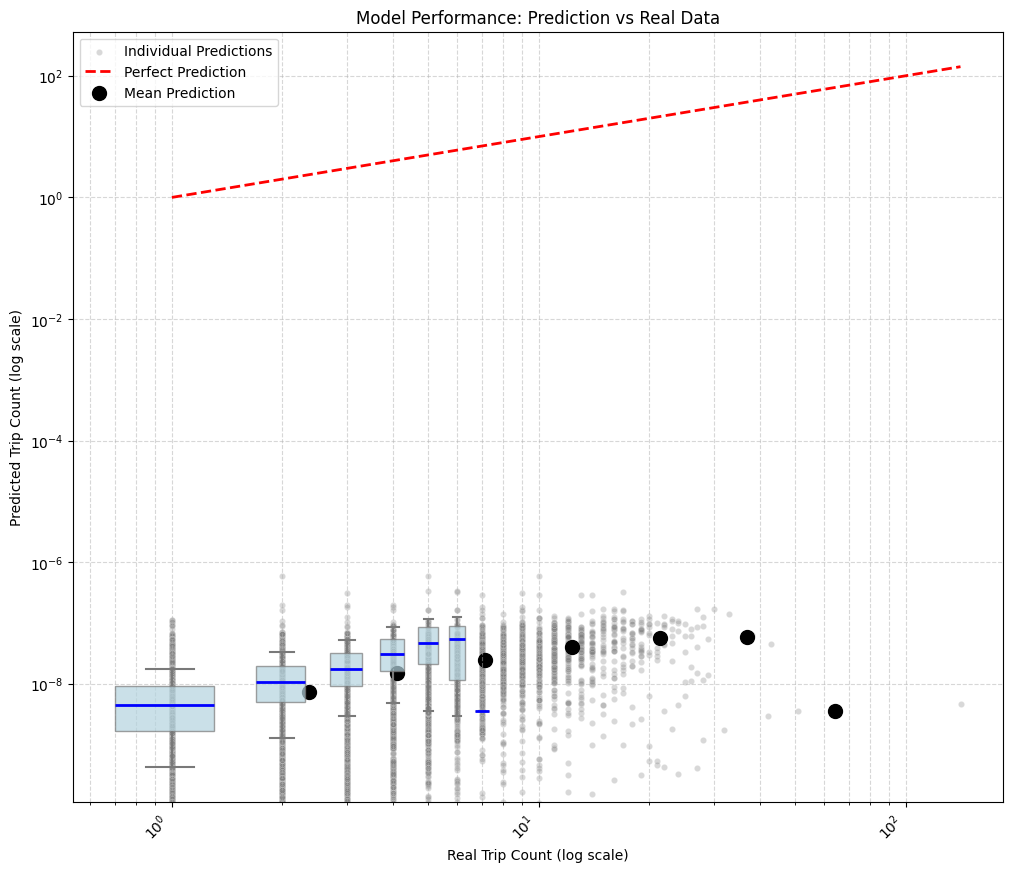

In [73]:
# 创建分箱
df['real_bin'] = pd.cut(df['real'], bins=np.logspace(0, np.log10(df['real'].max()), 10))

# 创建图形
plt.figure(figsize=(12, 10))

# 1. 灰色散点图
sns.scatterplot(
    x='real',
    y='pred',
    data=df,
    color='gray',
    alpha=0.3,
    s=20,
    label='Individual Predictions'
)

# 2. 红色对角线
x_range = np.linspace(df['real'].min(), df['real'].max(), 100)
plt.plot(x_range, x_range, color='red', linestyle='--', linewidth=2, label='Perfect Prediction')

# 3. 黑色点（均值）
mean_pred = df.groupby('real_bin')['pred'].mean().reset_index()
mean_pred['real_mid'] = mean_pred['real_bin'].apply(lambda x: x.mid)
plt.scatter(
    mean_pred['real_mid'],
    mean_pred['pred'],
    color='black',
    s=100,
    label='Mean Prediction'
)

# 4. 蓝色箱线图
sns.boxplot(
    x='real_bin',
    y='pred',
    data=df,
    color='lightblue',
    showfliers=False,
    width=0.6,
    whis=[9, 91],  # 设置9th和91st百分位数
    boxprops=dict(alpha=0.7),
    whiskerprops=dict(linestyle='-', linewidth=1.5),
    medianprops=dict(color='blue', linewidth=2),
    capprops=dict(linewidth=1.5)
)

# 设置对数坐标轴
plt.xscale('log')
plt.yscale('log')

# 设置标签和标题
plt.xlabel('Real Trip Count (log scale)')
plt.ylabel('Predicted Trip Count (log scale)')
plt.title('Model Performance: Prediction vs Real Data')

# 设置图例
plt.legend(loc='upper left')

# 设置坐标轴范围
x_min = df['real'].min()
x_max = df['real'].max()
y_min = df['pred'].min()
y_max = df['pred'].max()


# 设置网格
plt.grid(True, which='both', linestyle='--', alpha=0.5)

# 调整x轴标签
plt.xticks(rotation=45, ha='right')

# 保存图像
plt.savefig('./data/visualization/prediction_vs_real_full.png', dpi=300, bbox_inches='tight')
plt.show()

效果很差，估计是因为一日的出租车覆盖的范围太小了。